![paynoattentionman](./images/paynoattentionman.jpg "Pay no attention to that man behind the curtain")

These days, when people talk about machine learning, they are usually referring to the modern nonlinear methods that tend to win Kaggle competetitions: Random Forests, Gradient Boosted Trees, XGBoost, or the various forms of Neural Networks. People talk about how these modern methods generally provide lower bias and are able to better optimize an objective function than the more traditional methods like Linear Regression or Logistic Regression (for classification). However, when organizations- specifically organizations in heavily regulated industries like finance, healthcare, and insurance - talk about machine learning, they tend to talk about how they can't implement machine learning in their business because it's too much of a "black box." 

These organizations make underwriting and pricing decisions based on predictons for annual income, credit default risk, probability of death, disease risk, and many others. They worry about a series of regulatory requirements forcing them to explain why a particular decision was reached on a single sample, in a clear and defensible manner. Nobody wants to be the first to test a new regulatory standard and it is far easier to continue business-as-usual, so these organizations like their tidy formulas and interpretable coefficients and they won't give them up without good reason. From the perspective of a data scientist, that good reason is lower model bias leading to better predictions further leading to better customer experiences, a reduction in regulatory issues, and ultimately a stronger competitive advantage and higher profits for the enterprise. The first mover has much to gain, but also a lot to lose. By applying the techniques discussed here it should become clear there are ways to create value and effectively mitigate the regulatory risks involved. 

In recent years the "black box" nature of nonparametric machine learnings models has given way to several methods that help us crack open what is happening inside a complex model. Thanks to ongoing research in the field of ML model explainability, we now have at least five good methods with which we can explore the inner workings of our models. 

An exhaustive review of all methods is outside the scope of this article, but below is a non-exhaustive set of links for those interested in further research: 

 - [Feature Importance (XGBoost)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting)
 - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
 - [Partial Dependence](https://www.kaggle.com/dansbecker/partial-plots)
 - [LIME](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime)
 - [SHAP](https://github.com/slundberg/shap)

The goals of this post are to:
1. Build an XGBoost binary classifier 
2. Showcase SHAP to explain model predictions so a regulator can understand
3. Discuss some edge cases and limitations of SHAP in a multi-class problem

In [a well-argued piece](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27), one of the team members behind SHAP explains why this is the ideal choice for explaining ML models and is superior to other methods. SHAP stands for 'Shapley Additive Explanations' and it applies game theory to local explanations to create consistent and locally accurate additive feature attributions. If this doesn't make a lot of sense, don't worry, the graphs below will mostly speak for themselves. 

In this post I will demonstrate a simple XGBoost example for a binary and multiclass classification problem, and how to use SHAP to effectively explain what is going on under the hood. I will begin with a binary classifier using the [Titanic Survival Dataset](http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html). 

Then we will explain the predictions using SHAP plots like this one: 

![shap_example](./images/shap_example.png "SHAP example")

## 1. Build the Model

First we import the necessary packages:

In [424]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

Next, we import our data an look at a preview

In [425]:
titanic = pd.read_csv('./extra/data/titanic.csv')
print(titanic.shape)
titanic.head()

(891, 11)


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [426]:
#Check for missing values
print(titanic.isna().sum()[titanic.isna().sum()>0])

age         177
cabin       687
embarked      2
dtype: int64


Our target column is the binary `survived` and we will use every column except `name`, `ticket`, and `cabin`. First, we will create an engineered feature `family_size` by adding in the siblings and parents features. Then, we must deal with missing values in the `age` and `embarked` columns so we will impute values. Next, we need to dummy encode the two remaining text columns `sex` and `embarked`. Finally, we can drop extra columns, assign our X and y, and train our model. 

In [427]:
#store off the original data for later
titanic_orig = titanic

#Create family size engineered feature
titanic['family_size'] = titanic['sibsp'] + titanic['parch']

#impute missing age with mean age
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())

#impute missing embarked with mode
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode().values[0])

#dummy encode text columns
cols_to_encode = ['pclass','sex','embarked'] #,'cabin_letter'
titanic = pd.get_dummies(titanic, columns=cols_to_encode, drop_first=True)

#drop extra columns from X
cols_to_drop = ['survived','name','ticket','cabin']

y = titanic.loc[:,'survived']
X = titanic.drop(cols_to_drop, axis='columns')

display(X.head())
print('Survived class distribution: \n', y.value_counts(normalize = True),'\n')

,age,sibsp,parch,fare,family_size,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,22.0,1,0,7.2500,1,0,1,1,0,1
1,38.0,1,0,71.2833,1,0,0,0,0,0
2,26.0,0,0,7.9250,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,1,0,1


Survived class distribution: 
 0    0.616162
1    0.383838
Name: survived, dtype: float64 



Above, we see a sample of our final training dataset and below it the distribution of the survived column - only 38% of passengers survived! Because decision tree models are robust to multicollinearity and scaling - and because this is a very simple dataset - we can skip the usual EDA and data normalization procedures and jump to model training and evaluation. Below we train an XGBoost binary classifier using k-fold cross-validation to tune our hyperparameters to ensure an optimal model fit. 

In [1]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

grid_search = GridSearchCV(estimator=xgbcl, scoring='roc_auc', param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

NameError: name 'train_test_split' is not defined

We have now found our optimal hyperparameters optimizing for area under the Receiver Operating Characteristic (AUC ROC). Next, we will use those optimal hyperparameters to train our final model but first, because the dataset is so small, we will do a final k-fold cross-validation to get stable error metrics and ensure a good fit. 

In [439]:
#Set our final hyperparameters to the tuned values
xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
         colsample_bytree = grid_result.best_params_['colsample_bytree'], 
         learning_rate = grid_result.best_params_['learning_rate'], 
         max_depth = grid_result.best_params_['max_depth'], 
         subsample = grid_result.best_params_['subsample'], 
         n_estimators = grid_result.best_params_['n_estimators'])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#refit the model on k-folds to get stable avg error metrics
scores = cross_validate(estimator=xgbcl, X=X_train, y=y_train, cv=kfold, n_jobs=-1, 
                        scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

print('Training 5-fold Cross Validation Results:\n')
print('AUC: ', scores['test_roc_auc'].mean())
print('Accuracy: ', scores['test_accuracy'].mean())
print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1: ', scores['test_f1'].mean(), '\n')

Training 5-fold Cross Validation Results:

AUC:  0.8610985116938341
Accuracy:  0.8203344181348895
Precision:  0.8097487479840421
Recall:  0.6912941176470588
F1:  0.7437777576040261 



Above, we see a good AUC in the high 80's, and an accuracy in the 80's which is far better than guessing `0` every time yielding only a 61% accuracy. Next, we'll fit the final model and visualize the AUC. We can improve further by determining whether we care more about false positives or false negatives and tuning our prediction threshold accordingly, but this is good enough to stop and show off SHAP.

Classification report (Test): 

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       134
           1       0.80      0.74      0.77        89

   micro avg       0.82      0.82      0.82       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223

Confusion matrix (Test): 

[[0.52466368 0.07623318]
 [0.10313901 0.29596413]]

Train Accuracy: 0.8937125748502994
Test Accuracy: 0.820627802690583

Train AUC: 0.9496642697271298
Test AUC: 0.8747694113701157


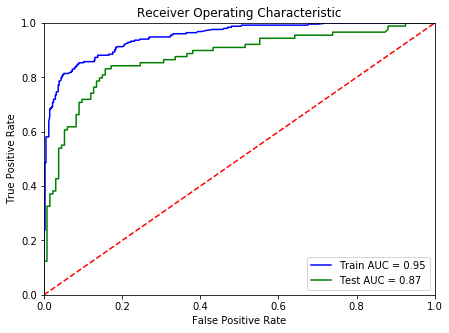

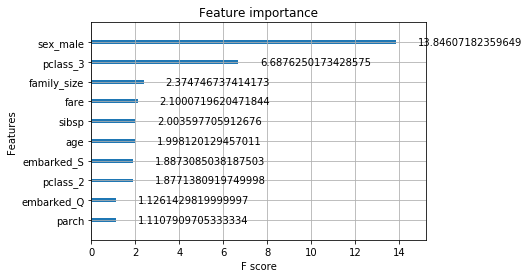

In [440]:
#Fit the final model
xgbcl.fit(X_train, y_train)

#Generate predictions against our training and test data
pred_train = xgbcl.predict(X_train)
proba_train = xgbcl.predict_proba(X_train)
pred_test = xgbcl.predict(X_test)
proba_test = xgbcl.predict_proba(X_test)

# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_test, pred_test))
print("Confusion matrix (Test): \n")
print(metrics.confusion_matrix(y_test, pred_test)/len(y_test))

print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, pred_test))

print ('\nTrain AUC:', metrics.roc_auc_score(y_train, proba_train[:,1]))
print ('Test AUC:', metrics.roc_auc_score(y_test, proba_test[:,1]))

# calculate the fpr and tpr for all thresholds of the classification
train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_train, proba_train[:,1])
test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_test, proba_test[:,1])

train_roc_auc = metrics.auc(train_fpr, train_tpr)
test_roc_auc = metrics.auc(test_fpr, test_tpr)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[7,5])
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# plot feature importance
xgb.plot_importance(xgbcl, importance_type='gain');

Above, we see the final model is making decent predictions with minor overfit. Using the built-in XGBoost feature importance method we see which attributes most reduced the loss function on the training dataset, in this case `sex_male` was the most important feature by far, followed by `pclass_3` which represents a 3rd class the ticket. We know from historical accounts that there were not enough lifeboats for everyone and two groups were prioritized: first class passengers and women with children. So, `sex` and `pclass` are justifiably important, but this method provides precious little to explain precisely why a prediction was made on a case-by-case basis. 

Now that we have a trained model, let us make a prediction on a random row of data, and then use SHAP to understand why this was predicted.

## 2. Use SHAP to Explain the Model

In [441]:
#take a random row of data
X_rand = X.sample(1, random_state = 5)
display(titanic_orig.iloc[X_rand.index])

#generate a prediction for the row
rand_pred = xgbcl.predict(X_rand)
rand_proba = xgbcl.predict_proba(X_rand)

print(f'Predicted Probability (no, yes): {rand_proba}')
print(f'Predicted Survival (0 = no, 1 = yes): {rand_pred}','\n')

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_size
126,0,3,"McMahon, Mr. Martin",male,29.699118,0,0,370372,7.75,NaN,Q,0


Predicted Probability (no, yes): [[0.8719378  0.12806217]]
Predicted Survival (0 = no, 1 = yes): [0] 



We see the input data of row 126 from the dataset belonging to a 29 year old male Mr. Martin McMahon posessing a 3rd class ticket, and the output prediction was `0` with an 87% probability. Because we are using the default threshold of 50% for a prediction one way or another, 87% is more than enough to trigger a prediction of `0`. But **why** did the model determine an 87% probability of death and only an 13% probability of survival for this particular passenger? This is the question a regulator wants answered if this passenger had survived and complains to the authority that he is very much alive and takes great offense at our inaccurate prediction. In this case, the model correctly predicted his unfortunate end, but even when we are right we still need to understand why. To gain this understanding we will import the SHAP package and explain this row of data. 

Before we do, its worth mentioning how SHAP actually works. Greatly oversimplyfing, SHAP takes the base value for the dataset, in our case a 0.38 chance of survival for anyone aboard, and goes through the input data row-by-row and feature-by-feature varying its values to detect how it changes the base prediction holding all-else-equal for that row. For non-linear models the order in which the features are added matters so SHAP values arise from averaging the values across all possible orderings. In so doing, SHAP is essentially building a mini explainer model for a single row-prediction pair to explain how this prediction was reached. The full source text is available [here](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf). Now, let's have a look at SHAP. 

In [442]:
import shap

explainer = shap.TreeExplainer(xgbcl, model_output='probability', feature_dependence='independent', data=X)
shap_values = explainer.shap_values(X.iloc[X_rand.index])
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, X.iloc[X_rand.index]))

#Display all features and SHAP values
display(pd.DataFrame(data=shap_values, columns=X.columns, index=[126]).transpose().sort_values(by=126, ascending=True))

,126
sex_male,-0.167284
fare,-0.054258
pclass_3,-0.050905
age,-0.026181
embarked_Q,-0.018607
parch,0.001453
sibsp,0.003610
pclass_2,0.004263
family_size,0.013252
embarked_S,0.034989


Seeing a SHAP plot is like seeing the magician behind the green curtain in the Wizard of Oz. Its beauty lies in how the distribution of feature effects are additive (adding up to the total predicted probability for the `1` class) and that they are localized to a single prediction. The table below the plot is the full list of features and their SHAP additive weights. We can see very clearly the model brought down his probability of survival by 16% because `sex_male == 1`, and by an additional 5% because `pclass_3 == 1`. On the other hand, in his case a `family_size == 0` slightly helped his odds along with `embarked_S == 0`. When deciding whether an input attribute value helped or hurt his chances SHAP assumes an *all else equal* logic - just as you would interpret coefficients (m) in a parametric model (y = mx + b). Furthermore, we can empirically show the additive nature of SHAP holds true: ```base value (0.38 survival rate for any given passenger) + SUM(SHAP values) == Predicted Probability of Survival```. 

In [471]:
#Prove the sum of SHAP values and base_value sum to our prediction for class 1
import math
shap_sum = explainer.expected_value + shap_values.sum()
assert(math.isclose(shap_sum,rand_proba[0][1],rel_tol=1e-06)) #if this was False, and error would be thrown

Now we can use SHAP to view how the features affected the probabilities for a larger sample. 

 96%|=================== | 857/891 [00:21<00:00]       

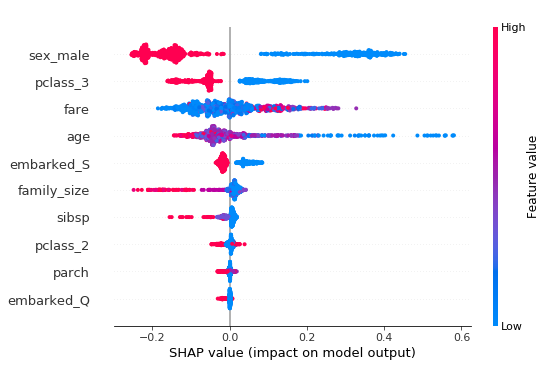

In [433]:
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Above, we see being male is generally a bad thing, but the horizontal dispersion also implies that it depends on other factors. If it did not, we would see a single blob of red on the `sex_male` line instead of points spread across the X-axis with varying negative SHAP values. At a glance we also see high values for `fare` tended to aid in survival probability, meanwhile low values for `age` greatly helped the survival odds. By looking at the SHAP dependence plots we can better understand the interdependence of the features. 

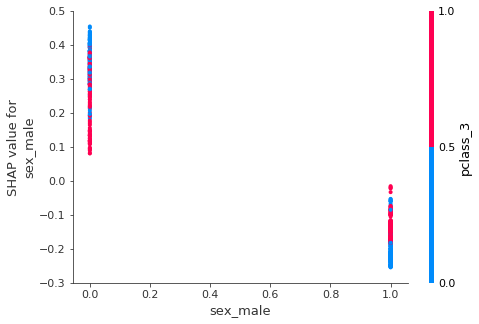

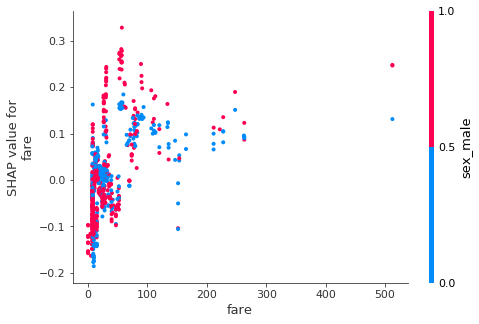

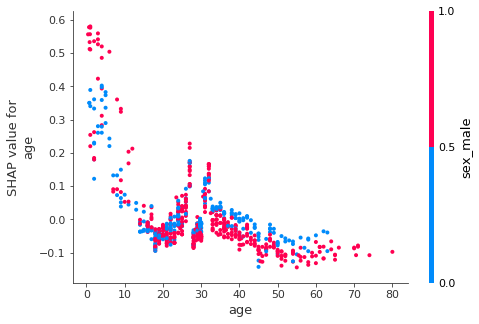

In [435]:
shap.dependence_plot('sex_male', shap_values, X, interaction_index='pclass_3')
shap.dependence_plot('fare', shap_values, X) #when we don't specify an interaction_index, the strongest one is automatically chosen for us
shap.dependence_plot('age', shap_values, X, interaction_index='sex_male')

With SHAP dependence plots we can see how `sex_male` influences the prediction and how in turn it is influenced by `pclass_3`. We see a clear benefit on survival of being a woman, and further being in 3rd class hurt your odds as a woman but had a lesser effect if you were a man (because the survival odds are already so bad). The model believes it was better to be a woman in 3rd class than almost any man. The second plot illustrates that a higher `fare` paid generally conferred a survival benefit, likely due to its influence on cabin class and therefore proximity to lifeboats. Finally, `age` is interesting because we see a clear benefit to being a child below the age of 10 through an increase in probability of survival, but then we see an interesting spike in the 25-35 range. Further analysis would be warranted but this could be due to the most common ages of the parents who were prioritized alongside their children. We also see more evidence that being a woman at almost any age is better than being a man in terms of survivability. 

If a regulator were to ask why a decision was made, SHAP can be used to demonstrate exactly which factors added up to the final decision and how they interacted with each other, even in a complex gradient boosted tree ensemble. 

## 3. Multi-class SHAP Example
So now, let us move to a multi-class example. In this case its a bit more complex because SHAP has certain multi-class limitations. I'll keep the model building short so we can focus on the differences from binary classification with SHAP. 

In [381]:
#For the multi-class example we use iris dataset
X,y = shap.datasets.iris()
X_display,y_display = shap.datasets.iris(display=True) # human readable feature values

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgbc = xgb.XGBClassifier(learning_rate=0.5,
                    n_estimators=150,
                    max_depth=6,
                    min_child_weight=0,
                    gamma=0,
                    reg_lambda=1,
                    subsample=1,
                    colsample_bytree=0.75,
                    scale_pos_weight=1,
                    objective='multi:softprob',
                    num_class=3,
                    random_state=42)

mcl = xgbc.fit(X_train, y_train, eval_metric='mlogloss')
pred = mcl.predict(X_test)
proba = mcl.predict_proba(X_test)

#store our flower labels for results
y_map = pd.DataFrame(data=y, columns=['class'])
y_map['label'] = y_map['class'].map({0:'Iris-setosa',1:'Iris-versicolor',2:'Iris-virginica'})

In [422]:
#Attempt to use SHAP on multi-class
X_rand = X.sample(1, random_state=42)
idx = X_rand.index.values[0]

#This line will not work for a multi-class model, so we comment out
#explainer = shap.TreeExplainer(mcl, model_output='probability', feature_dependence='independent', data=X)

explainer = shap.TreeExplainer(mcl)
shap_values = explainer.shap_values(X.iloc[idx])
shap.initjs()
for which_class in range(0,3):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))
    
#Display all features and SHAP values
df1=pd.DataFrame(data=shap_values[0], columns=X.columns, index=[0])
df2=pd.DataFrame(data=shap_values[1], columns=X.columns, index=[1])
df3=pd.DataFrame(data=shap_values[2], columns=X.columns, index=[2])
df=pd.concat([df1,df2,df3])
display(df.transpose())

,0,1,2
sepal length (cm),0.000000,0.280146,0.517233
sepal width (cm),0.000000,-0.117666,0.496995
petal length (cm),-3.519863,2.635099,-1.534398
petal width (cm),-1.022237,2.000855,-2.015610


This first obvious difference is SHAP will output a seperate matrix for each class prediction for the given input row. This means we have 3 plots to look at instead of just one. This is useful because a regulator may be just as interested in why you made a decision as they are in why you didn't make another. Thankfully its easy to loop through each class and generate the appropriate graphs. 

As of May 2019 SHAP has some limitations in the multi-class usecase. The first is the explainer methods (Tree and Kernel) cannot output probabilities due to a limitation dealing with non-linear transforms, they can only output the raw margin values of the objective function used to fit the model. To make matters worse, if you try to run the commented line in the above code the error generated is confusing and does not specify the actual problem: 
>Exception: When model_output is not "margin" then we need to know the model's objective. Unfortuneately raw XGBoost Booster objects don't expose this information. Consider using the XGBRegressor/XGBClassifier objects, or annotate the Booster object with the objective you are using, for example: xgb_model.set_attr(objective="binary:logistic").

Instead of the usual `binary:logistic` (using which SHAP can output probabilities) our XGBoost objective function for multi-class is typically either `multi:softmax` or `multi:softprob` so the output is Log Odds. More on all of the possible XGBoost objective functions [here](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters).  These are both generalized logistic objective functions and the output of `model.predict_proba()` will yield class probabilities that sum to 1 across n classes, but SHAP can only display the Log Odds. 

This makes interpretation of the SHAP plots a bit more difficult but not impossible - here we determine the largest output value to be the predicted class, and a value of 0 implies a 50% probability. 

The second catch comes if you want to convert the Log Odds values to a probability. Normally, to go from Log Odds to Probability we use the conversion rule: 

\begin{equation*}
P(x)   = \frac{e^{ln(odds)}}{1 + e^{ln(odds)}}\
\end{equation*}

The above works fine for Binary Classification models where we only have 2 classes. But for a multi-class classification model we must instead use the following formulation: 

\begin{equation*}
P(x)   = \frac{e^{ln(odds)}}{\sum_{}e^{ln(odds)}}\
\end{equation*}

Let's do the conversion and test to ensure it matches the output of `model.predict_proba()`.

In [423]:
#define a function to convert logodds to probability for multi-class 
def logodds_to_proba(logodds):
    return np.exp(logodds)/np.exp(logodds).sum()

#generate predictions for our row of data and do conversion
logodds = mcl.predict(X_rand, output_margin=True)
probas = mcl.predict_proba(X_rand)
for which_class in range(0,3):
    base_val = explainer.expected_value[which_class]
    pred_val = explainer.expected_value[which_class] + shap_values[which_class][0].sum() #delta between base value and pred value
    converted_prob_val = logodds_to_proba(logodds)[0][which_class]
    proba = probas[0][which_class]

    print('Class: ',which_class)
    print('Base value: ', base_val)
    print('Prediction value: ', pred_val)
    print('Converted Proba value:', converted_prob_val)
    print('Proba value:', proba, '\n')

Class:  0
Base value:  0.3422814
Prediction value:  -4.199818
Converted Proba value: 5.1404942e-05
Proba value: 5.1404906e-05 

Class:  1
Base value:  0.87670594
Prediction value:  5.675141
Converted Proba value: 0.9991854
Proba value: 0.99918526 

Class:  2
Base value:  1.0338581
Prediction value:  -1.5019219
Converted Proba value: 0.0007632843
Proba value: 0.00076328433 



As you can see, this conversion works as expected, and we are able to back out of the values used by the SHAP graphs to match our predicted probabilities from the model. This SHAP limitation will likely be fixed in the coming months as the issue is currently open on the repository. For those who don't have a need to output the probabilities and are comfortable working directly with Log Odds values, then this is no limitation at all. Because conversion is possible, SHAP is just as useful when explaining a multi-class model to anyone who needs to understand *why* a particular prediction was made. 

## Conclusion

I hope this post was helpful in demonstrating how to train an XGBoost classifier, and most importantly, how to use SHAP to effectively understand and explain why a specific prediction was made. As companies demonstrate these tools to regulators and as they begin to use these tools themselves, the doors should open to using Machine Learning in places never before thought possible. Ultimately, the benefits of these advancements when used wisely and applied fairly should help both consumers and the enterprises serving them. 